In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import os
import subprocess
import importlib as imp
import csv
import sys
from pygsm import GlobalSkyModel2016
from pygsm import GlobalSkyModel
from pygsm import GlobalSkyModel
from pygsm import GSMObserver
from datetime import datetime
import healpy
from importlib import reload  
from scipy.interpolate import interp1d
import h5py
from astropy.time import Time
from scipy.interpolate import griddata
#import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from astropy.modeling import models, fitting

In [2]:
def plot_versus_freq(freq,yplots,labels,xlims,ylims,dx,dy,yaxlabel,title,filename,linestl,lineclr,lw,smooth,dfreq):
    fs = 16
    xtlabels = np.linspace(xlims[0],xlims[1],int(np.floor((xlims[1]-xlims[0])/dx))+1)
    ytlabels = np.linspace(ylims[0],ylims[1],int(np.floor((ylims[1]-ylims[0])/dy))+1)
    fig = plt.figure(figsize=(15,8))
    if smooth > 0.:
        for i in range(0,len(yplots)):
            numpts = int((xlims[1]-xlims[0])/dfreq)+1
            smthplot = np.zeros([numpts])
            fcent = np.zeros([numpts])
            for j in range(0,numpts):
                fcent[j] = (j*dfreq + xlims[0])
                smthplot[j] = np.nanmedian(yplots[i][np.where((freq<fcent[j]+(smooth)/2.) 
                                                              & (freq>fcent[j]-(smooth)/2.))[0]])
            plt.plot(fcent,smthplot,label=labels[i],linestyle=linestl[i],c=lineclr[i],linewidth=lw)
    else:
        for i in range(0,len(yplots)):
            plt.plot(freq,yplots[i],label=labels[i],linestyle=linestl[i],c=lineclr[i],linewidth=lw)
    plt.grid()
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0],ylims[1])
    plt.legend(fontsize=fs)
    plt.xticks(xtlabels,fontsize=fs)
    plt.yticks(ytlabels,fontsize=fs)
    plt.xlabel('Frequency (MHz)',fontsize=fs)
    plt.ylabel(yaxlabel,fontsize=fs)
    plt.title(title,fontsize=fs+2)
    plt.savefig(filename)
    return

def plot_sky_bright(freq,freq_pts,sky_interp,sky_pts,xlims,ylims,dx,dy,title,filename):
    fs = 16
    xtlabels = np.linspace(xlims[0],xlims[1],int(np.floor((xlims[1]-xlims[0])/dx))+1)
    ytlabels = np.linspace(ylims[0],ylims[1],int(np.floor((ylims[1]-ylims[0])/dy))+1)
    fig = plt.figure(figsize=(15,8))
    
    plt.plot(freq,sky_interp,c='black',linewidth=2,zorder=0)
    plt.scatter(freq_pts,sky_pts,c='red',s=50,zorder=10)
    
    plt.grid()
    plt.xlim(xlims[0],xlims[1])
    plt.ylim(ylims[0],ylims[1])
    plt.xticks(xtlabels,fontsize=fs)
    plt.yticks(ytlabels,fontsize=fs)
    plt.xlabel('Frequency (MHz)',fontsize=fs)
    plt.ylabel('Sky brightness [K]',fontsize=fs)
    plt.title(title,fontsize=fs+2)
    plt.savefig(filename)
    return

def read_in_data(file_in):
    
    file = h5py.File(file_in,'r')
    print(file)

    dataset = file['data']['beam_0']['band_SB0']['scan_0']

    # Add the position and time data to the corresponding arrays:
    dec = dataset['metadata']['declination']
    ra = dataset['metadata']['right_ascension']
    el = dataset['metadata']['elevation']
    az = dataset['metadata']['azimuth']
    t = dataset['metadata']['utc']
    noise = dataset['metadata']['noise_state']
    freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6
    RR = dataset['data'][:,0,:]
    LL = dataset['data'][:,1,:]
    reRL = dataset['data'][:,2,:]
    imRL = dataset['data'][:,3,:]

    t_plt = Time(t, format='isot',scale='utc').mjd
    
    return ra, dec, az, el, t, noise, freq, RR, LL, reRL, imRL, t_plt


def time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                 noise_pick=None,*args,**kwargs):
    
    t_plt1 = Time(t1, format='isot',scale='utc').mjd
    t_plt2 = Time(t2, format='isot',scale='utc').mjd
    
    #print(t_plt1)
    #print(t_plt2)
    
    
    if noise_pick == True:
        print('calculating noise on states')
        tidx = np.where((t_plt>t_plt1) & (t_plt<t_plt2) & (noise==1))[0]
        print(len(tidx))
        LL_mean = np.nanmedian(LL[tidx,:],axis=0)
        RR_mean = np.nanmedian(RR[tidx,:],axis=0)
        
    if noise_pick == False:
        print('calculating noise off states')
        tidx = np.where((t_plt>t_plt1) & (t_plt<t_plt2) & (noise==0))[0]
        print(len(tidx))
        LL_mean = np.nanmedian(LL[tidx,:],axis=0)
        RR_mean = np.nanmedian(RR[tidx,:],axis=0)
        
    if noise_pick == None:
        print('calculating average of all points')
        tidx = np.where((t_plt>t_plt1) & (t_plt<t_plt2))[0]
        print(len(tidx))
        LL_mean = np.nanmedian(LL[tidx,:],axis=0)
        RR_mean = np.nanmedian(RR[tidx,:],axis=0)
        

    return RR_mean, LL_mean
    

In [3]:
t1 = '2023-06-27T17:02:00.0'
t2 = '2023-06-27T17:19:00.0'
ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt = read_in_data('/home/ordoga/DVA_June2023/absorber_on.h5')
P1_close_off, P2_close_off = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=False)
P1_close_on, P2_close_on = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=True)

t1 = '2023-06-27T17:31:00.0'
t2 = '2023-06-27T17:48:00.0'
ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt = read_in_data('/home/ordoga/DVA_June2023/absorber_off.h5')
P1_open_off, P2_open_off = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=False)
P1_open_on, P2_open_on = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=True)


<HDF5 file "absorber_on.h5" (mode r)>
calculating noise off states
899
calculating noise on states
800
<HDF5 file "absorber_off.h5" (mode r)>
calculating noise off states
999
calculating noise on states
700


/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
 

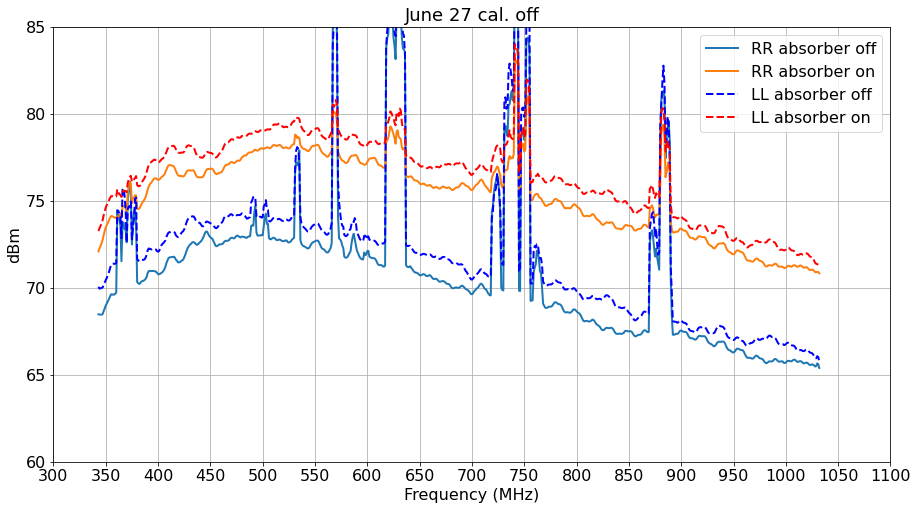

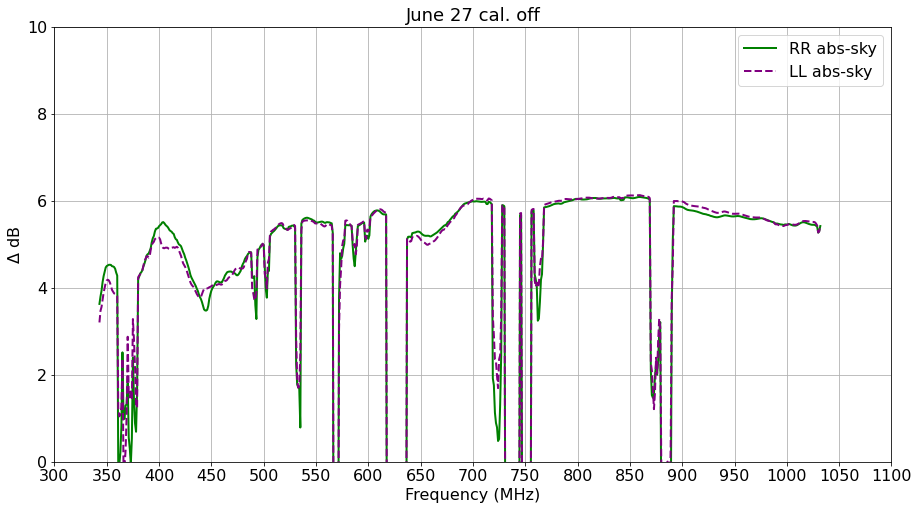

In [4]:
######################################################################
lw = 2              # linewidth on plots
smooth=2.           # frequency range for boxcar smoothing (set to zero for no smoothing)
dfreq=1.            # frequency increment for boxcar smoothing
######################################################################

yplots = [10*np.log10(P1_open_off),10*np.log10(P1_close_off),
          10*np.log10(P2_open_off),10*np.log10(P2_close_off)]
labels = ['RR absorber off', 'RR absorber on', 'LL absorber off', 'LL absorber on']

linestl = ['solid','solid','dashed','dashed']
lineclr = ['C0','C1','blue','red']
yaxlabel = 'dBm'
filename = '/home/ordoga/DVA_June2023/absorber_on_off.pdf'
plot_versus_freq(freq,yplots,labels,[300,1100],[60,85],50,5,yaxlabel,'June 27 cal. off',
                      filename,linestl,lineclr,lw,smooth,dfreq)

yplots = [10*np.log10(P1_close_off)-10*np.log10(P1_open_off),
          10*np.log10(P2_close_off)-10*np.log10(P2_open_off)]
labels = ['RR abs-sky','LL abs-sky']

linestl = ['solid','dashed']
lineclr = ['green','purple']
yaxlabel = r'$\Delta$ dB'
filename = '/home/ordoga/DVA_June2023/absorber_on_off_diff.pdf'
plot_versus_freq(freq,yplots,labels,[300,1100],[0,10],50,2,yaxlabel,'June 27 cal. off',
                      filename,linestl,lineclr,lw,smooth,dfreq)

/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
 

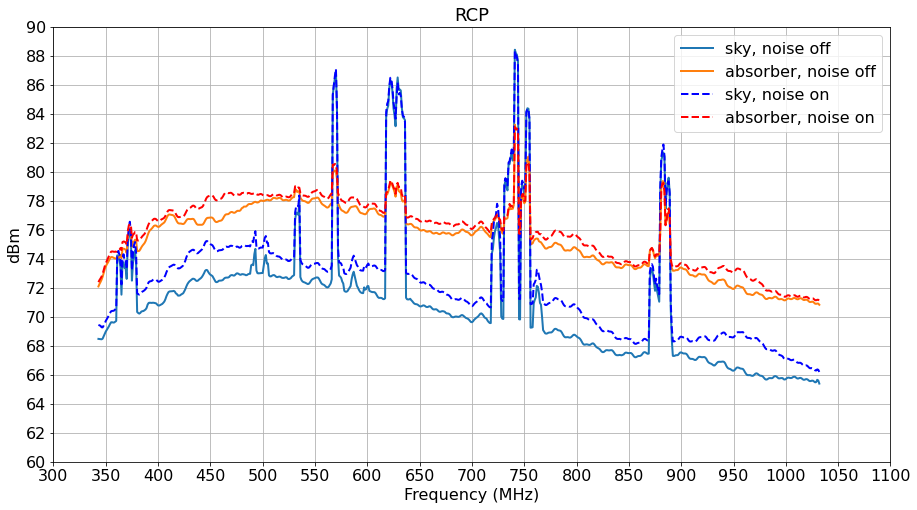

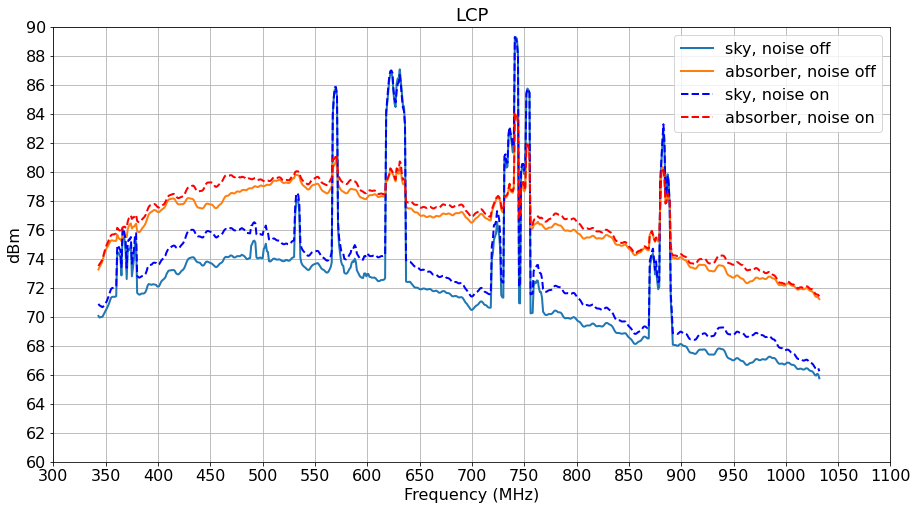

In [5]:
lw = 2              # linewidth on plots

yplots = [10*np.log10(P1_open_off),10*np.log10(P1_close_off),
          10*np.log10(P1_open_on),10*np.log10(P1_close_on)]
labels = ['sky, noise off', 'absorber, noise off', 
          'sky, noise on', 'absorber, noise on']
linestl = ['solid','solid','dashed','dashed']
lineclr = ['C0','C1','blue','red']
yaxlabel = 'dBm'
filename = '/home/ordoga/DVA_June2023/noise_RCP.pdf'
plot_versus_freq(freq,yplots,labels,[300,1100],[60,90],50,2,yaxlabel,'RCP',
                      filename,linestl,lineclr,lw,smooth,dfreq)

yplots = [10*np.log10(P2_open_off),10*np.log10(P2_close_off),
          10*np.log10(P2_open_on),10*np.log10(P2_close_on)]
labels = ['sky, noise off', 'absorber, noise off', 
          'sky, noise on', 'absorber, noise on']
linestl = ['solid','solid','dashed','dashed']
lineclr = ['C0','C1','blue','red']
yaxlabel = 'dBm'
filename = '/home/ordoga/DVA_June2023/noise_LCP.pdf'
plot_versus_freq(freq,yplots,labels,[300,1100],[60,90],50,2,yaxlabel,'LCP',
                      filename,linestl,lineclr,lw,smooth,dfreq)


In [9]:
rproj = 3.
numfreq = 25
(latitude, longitude, elevation) = ('49.3', '-119.6', 542)
dt = [2021, 3, 12, 19, 45, 0]

freq_sample = np.linspace(freq[0],freq[-1],numfreq)

ipix = np.linspace(0,3145727,3145728).astype(int)
theta, phi = np.degrees(healpy.pix2ang(nside=512, ipix=ipix))
wbad = np.where( (np.sqrt((theta-90.)**2+(phi)**2)>rproj) & 
                (np.sqrt((theta-90.)**2+(phi-360.)**2)>rproj) )

SB = np.empty(numfreq)

ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = datetime(dt[0],dt[1],dt[2],dt[3],dt[4],dt[5])
for i in range(0,numfreq):
    if i == int(np.ceil(numfreq/2.)):
        print('halfway')
    sb_arr = ov.generate(freq_sample[i])
    sb_arr[wbad] = np.nan
    SB[i] = np.mean(sb_arr[np.isfinite(sb_arr)])

interp_func = interp1d(freq_sample,SB,kind='cubic')
SB_interp = interp_func(freq)

halfway


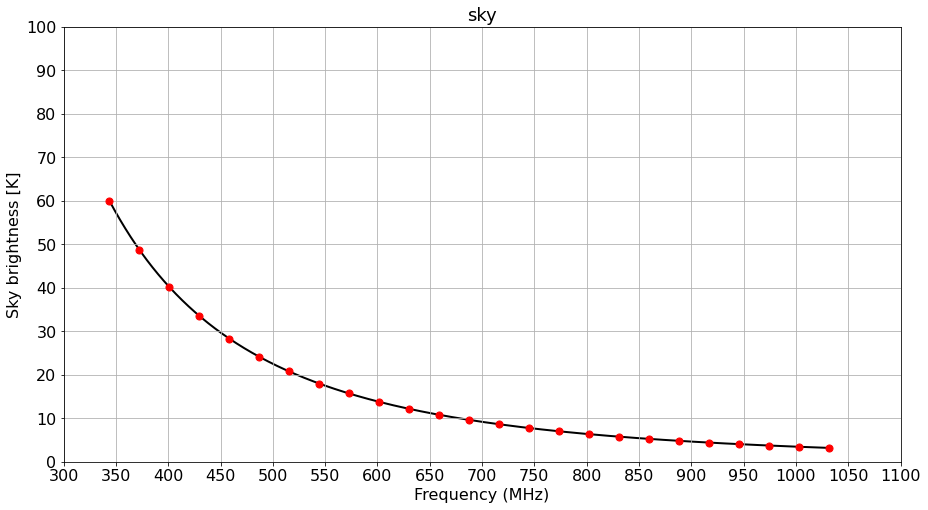

In [8]:
filename = '/home/ordoga/DVA_June2023/sky.pdf'
plot_sky_bright(freq,freq_sample,SB_interp,SB,[300,1100],[0,100],50,10,'sky',filename)


In [10]:
t1 = '2023-06-27T18:11:00.0'
t2 = '2023-06-27T18:23:00.0'
ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt = read_in_data('/home/ordoga/DVA_June2023/cold_load.h5')
RR_cold, LL_cold = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=False)

t1 = '2023-06-27T18:34:00.0'
t2 = '2023-06-27T18:42:00.0'
ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt = read_in_data('/home/ordoga/DVA_June2023/ambient.h5')
RR_amb, LL_amb = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=False)

t1 = '2023-06-27T18:25:00.0'
t2 = '2023-06-27T18:32:00.0'
ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt = read_in_data('/home/ordoga/DVA_June2023/hot_load.h5')
RR_hot, LL_hot = time_average(ra,dec,az,el,t,noise,freq,RR,LL,reRL,imRL,t_plt,t1,t2,
                                 noise_pick=False)

<HDF5 file "cold_load.h5" (mode r)>
calculating noise off states
799
<HDF5 file "ambient.h5" (mode r)>
calculating noise off states
399
<HDF5 file "hot_load.h5" (mode r)>
calculating noise off states
299


(0.0, 100000000.0)

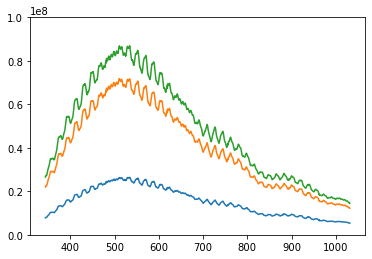

In [11]:
plt.plot(freq,RR_cold)
plt.plot(freq,RR_amb)
plt.plot(freq,RR_hot)
plt.ylim(0,1e8)

In [12]:
print(RR_cold.shape)

(8250,)


In [13]:
temps = np.array([80,29+273.15,98.4+273.15])


In [14]:
slopes = np.empty_like(freq)

for i in range(0,len(freq)):
    
    slopes[i], b = np.polyfit(temps, np.array([RR_cold[i],RR_amb[i],RR_hot[i]]), 1)

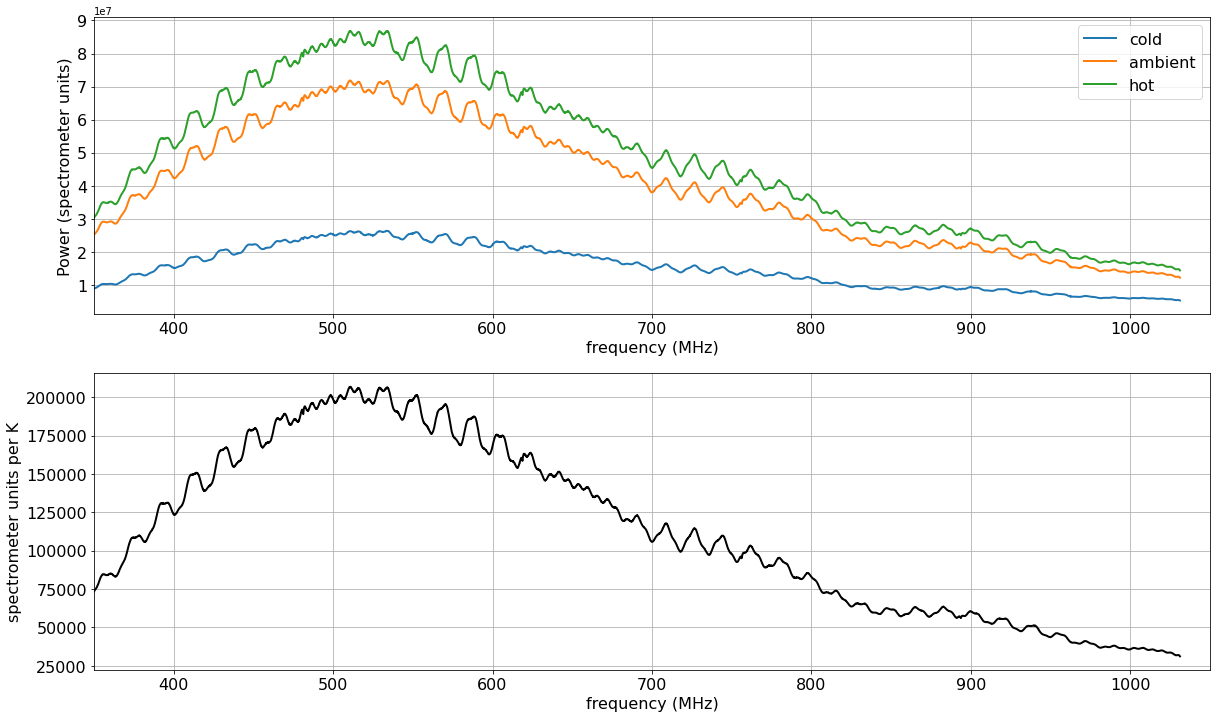

In [15]:
fig1, axs = plt.subplots(2,1,figsize=(20,12))

fs = 16

axs[0].plot(freq,RR_cold,label='cold',linewidth=2)
axs[0].plot(freq,RR_amb,label='ambient',linewidth=2)
axs[0].plot(freq,RR_hot,label='hot',linewidth=2)
axs[0].set_ylabel('Power (spectrometer units)',fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(freq,slopes,color='k',linewidth=2)
axs[1].set_ylabel('spectrometer units per K',fontsize=fs)

for i in range(0,2):
    axs[i].set_xlabel('frequency (MHz)',fontsize=fs)
    axs[i].tick_params(axis="x", labelsize=fs)
    axs[i].tick_params(axis="y", labelsize=fs)
    axs[i].set_xlim(350,1050)
    axs[i].grid()
    
plt.savefig('/home/ordoga/Python/DVA2/PLOTS/hot_cold_June2023.pdf')

In [20]:
np.save('/home/ordoga/DVA_June2023/computer_per_K.npy',(freq,slopes))

In [21]:
this = np.load('/home/ordoga/DVA_June2023/computer_per_K.npy')

In [22]:
print(this)

[[  343.77083333   343.85416667   343.9375     ...  1031.02083333
   1031.10416667  1031.1875    ]
 [64143.22994084 64368.99223628 64690.3482163  ... 31445.6023561
  31308.66768609 31172.07199142]]
